In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import floor
from sklearn.preprocessing import StandardScaler
import torch
torch.manual_seed(17)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.optim import Adam, SGD
from math import floor
from torch.utils.data import Dataset
from __future__ import division
import math
from PIL import Image, ImageOps
try:
    import accimage
except ImportError:
    accimage = None
import numbers
import types
import collections
from math import ceil

In [ ]:
device =torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!unzip -uq "/content/drive/MyDrive/DL_HW2/camvid.zip" -d "/content" #unzipping zipped file of pictures on \content
!unzip -uq "/content/drive/MyDrive/DL_HW2/LabeledApproved_full.zip" -d "/content"

In [ ]:
#Defining a dictionary for classes
a_file = open("/content/drive/MyDrive/DL_HW2/classes.txt","r")
list_of_lists = [(line.strip()).split() for line in a_file]
names=[l for i,j,k,l in list_of_lists]
colors=[np.asarray([int(i),int(j),int(k)]) for i,j,k,l in list_of_lists]
classes_num={}
for i in range(32):
  classes_num[i]=colors[i]


In [ ]:
lst1=listdir('/content/camvid/images')
lst1.remove('test.txt')
lst1.remove('Seq05VD_f02610.png') # pixels for this pic's label are out of range

lst1=[i.split('.')[0] for i in lst1]
random.seed(10)
random.shuffle(lst1) #list of base of names


In [ ]:
class MakingTensor(object): #I refined torch.ToTensor() source code so it doesn't change tensor range to 0-1
#https://pytorch.org/docs/0.2.0/_modules/torchvision/transforms.html#ToTensor
    def __call__(self, pic):
  
        if isinstance(pic, np.ndarray):

            img = torch.from_numpy(pic.transpose((2, 0, 1)))

            return img.int()

        if accimage is not None and isinstance(pic, accimage.Image):
            nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
            pic.copyto(nppic)
            return torch.from_numpy(nppic)

        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))

        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
 
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.int()
        else:
            return img


In [ ]:
#https://www.kaggle.com/drnykterstein/camvid-semantic-segmentation
#I used their idea for this mask, yet I did some modifications
def adjust_mask(mask,cls2rgb):
    mask=mask.numpy()
    mask=np.rollaxis(mask,0,3)
    semantic_map = np.zeros((360,480))
    i=1
    for colour in list(cls2rgb.values()):        
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis = -1)
        class_map=np.int32(class_map)*i
        semantic_map=semantic_map+class_map
        i=i+1
    return semantic_map

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.enc_A_conv=nn.Conv2d(3,64,7,padding=3)
    self.enc_A_BN=nn.BatchNorm2d(64)
    self.enc_A_maxpool=nn.MaxPool2d(2,stride=2,return_indices=True)

    self.enc_B_conv=nn.Conv2d(64,64,7,padding=3)
    self.enc_B_BN=nn.BatchNorm2d(64)
    self.enc_B_maxpool=nn.MaxPool2d(2,stride=2,return_indices=True)

    self.enc_C_conv=nn.Conv2d(64,64,7,padding=3)
    self.enc_C_BN=nn.BatchNorm2d(64)
    self.enc_C_maxpool=nn.MaxPool2d(2,stride=2,return_indices=True)

    self.enc_D_conv=nn.Conv2d(64,64,7,padding=3)
    self.enc_D_BN=nn.BatchNorm2d(64)
    self.enc_D_maxpool=nn.MaxPool2d(2,stride=2,return_indices=True)

    self.dec_D_uppool=nn.MaxUnpool2d(2,stride=2)
    self.dec_D_conv=nn.Conv2d(64,64,7,padding=3)
    self.dec_D_BN=nn.BatchNorm2d(64)

    self.dec_C_uppool=nn.MaxUnpool2d(2,stride=2)
    self.dec_C_conv=nn.Conv2d(64,64,7,padding=3)
    self.dec_C_BN=nn.BatchNorm2d(64)

    self.dec_B_uppool=nn.MaxUnpool2d(2,stride=2)
    self.dec_B_conv=nn.Conv2d(64,64,7,padding=3)
    self.dec_B_BN=nn.BatchNorm2d(64)

    self.dec_A_uppool=nn.MaxUnpool2d(2,stride=2)
    self.dec_A_conv=nn.Conv2d(64,64,7,padding=3)
    self.dec_A_BN=nn.BatchNorm2d(64)

    self.Soft_Max=nn.Conv2d(64,32,1)#It is not a real softmax layer!
    #I just name it as one!
    #It is a Conv layer and CrossEntropy will apply real Softmax to this layer later

  def forward(self,X):
    X=self.enc_A_conv(X)
    X=self.enc_A_BN(X)
    X=F.relu(X)
    X, ind_A=self.enc_A_maxpool(X)

    X=self.enc_B_conv(X)
    X=self.enc_B_BN(X)
    X=F.relu(X)
    X, ind_B=self.enc_B_maxpool(X)

    X=self.enc_C_conv(X)
    X=self.enc_C_BN(X)
    X=F.relu(X)
    X, ind_C=self.enc_C_maxpool(X)
    

    X=self.enc_D_conv(X)
    X=self.enc_D_BN(X)
    X=F.relu(X)
    X, ind_D=self.enc_D_maxpool(X)


    size_indC=ind_C.size()

    X=self.dec_D_uppool(input=X, indices=ind_D,output_size=size_indC)
    X=self.dec_D_conv(X)
    X=self.dec_D_BN(X)

    

    X=self.dec_C_uppool(input=X, indices=ind_C)
    X=self.dec_C_conv(X)
    X=self.dec_C_BN(X)


    X=self.dec_B_uppool(input=X, indices=ind_B)
    X=self.dec_B_conv(X)
    X=self.dec_B_BN(X)


    X=self.dec_A_uppool(input=X, indices=ind_A)
    X=self.dec_A_conv(X)
    X=self.dec_A_BN(X)


    X=self.Soft_Max(X)#It is not a real softmax layer!
    #I just name it as one!
    #It is a Conv layer and CrossEntropy will apply real Softmax to this layer later
    return X



In [ ]:
#https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
#I used their tutorial Here
class Customized_Dataset(Dataset):
  def __init__(self,ID_lst,labels,ground_pic_root,label_root): #labels= one_hot_classes dictionary
    self.ID_lst=ID_lst
    self.labels=labels
    self.ground_pic_root=ground_pic_root
    self.label_root=label_root


  def __len__(self):
    return len(self.ID_lst)

  

  def adjust_mask(self,mask):
    mask=mask.numpy()
    mask=np.rollaxis(mask,0,3)
    semantic_map = np.zeros((360,480))
    i=0
    for colour in list(self.labels.values()):        
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis = -1)
        class_map=np.int32(class_map)*i
        semantic_map=semantic_map+class_map
        i=i+1
    semantic_map=torch.from_numpy(semantic_map)
    return semantic_map


  def __getitem__(self,index):
    name = self.ID_lst[index]
    
    transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((360,480),interpolation=Image.NEAREST)])

    img=Image.open(self.ground_pic_root+name+'.png')
    img=transform(img)

    label_transform=transforms.Compose([MakingTensor(),transforms.Resize((360,480),interpolation=Image.NEAREST)])

    label_pic=Image.open(self.label_root+name+'_L.png')
    label_pic=label_transform(label_pic)
    label_final=self.adjust_mask(label_pic)

    return img,label_final

In [ ]:

ground_pic_root='/content/camvid/images/'
label_root='/content/LabeledApproved_full/'

ID_lst=lst1[:400]

params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 6}


training_set = Customized_Dataset(ID_lst, classes_num,ground_pic_root,label_root)
training_generator = torch.utils.data.DataLoader(training_set, **params)

params2 = {'batch_size': 5,
          'shuffle': True,
          'num_workers': 6}

ID_val=lst1[400:500]
validation_set=Customized_Dataset(ID_val, classes_num,ground_pic_root,label_root)
val_generator = torch.utils.data.DataLoader(validation_set, **params2)

In [ ]:
Network=Net()
Network.to(device)
criterian=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Network.parameters(), lr=0.01,momentum=0.9)


In [ ]:
epochs=100
running_loss=0

train_loss_pe=[] #pe: per epoch
val_loss_pe=[]

n_batch_train=ceil(400/params['batch_size'])
n_batch_val=ceil(100/params2['batch_size'])


for epoch in range(epochs):
  tr_l_pe=0
  val_l_pe=0
  for i ,data_train in enumerate(training_generator,0):
    inputs_train,labels_train=data_train[0].to(device),data_train[1].to(device)
    optimizer.zero_grad()
    outputs_train=Network(inputs_train)
    labels_train=labels_train.long()
    loss=criterian(outputs_train,labels_train)
    loss.backward()
    optimizer.step()
    

    running_loss+=loss.item()
    tr_l_pe+=loss.item()
    if i%20==19:
      print('[%d,%5d] loss: %f'%(epoch+1,i+1,running_loss/20))
      running_loss=0
  train_loss_pe.append(tr_l_pe/n_batch_train)

  for i ,data_val in enumerate(val_generator,0):
    inputs_val,labels_val=data_val[0].to(device),data_val[1].to(device)
    outputs_val=Network(inputs_val)
    labels_val=labels_val.long()
    loss_val=criterian(outputs_val,labels_val)
    val_l_pe+=loss_val.item()

  val_loss_pe.append(val_l_pe/n_batch_val)
  print('val loss per epoch: ',val_l_pe/n_batch_val)


  print('epoch',epoch+1)
print('finished training')

# output of this cell was cleared

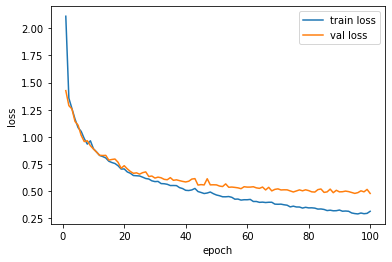

In [ ]:

plt.figure
x=list(range(1,epochs+1))
plt.plot(x,train_loss_pe)
plt.plot(x,val_loss_pe)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss','val loss'])

In [ ]:
params3 = {'batch_size': 3,
          'shuffle': True,
          'num_workers': 6}

ID_test=lst1[600:603]
test_set=Customized_Dataset(ID_test, classes_num,ground_pic_root,label_root)
test_generator = torch.utils.data.DataLoader(test_set, **params3)

for i ,data_test in enumerate(test_generator,0):
    inputs_test,labels_test=data_test[0].to(device),data_test[1].to(device)
    outputs_test=Network(inputs_test)


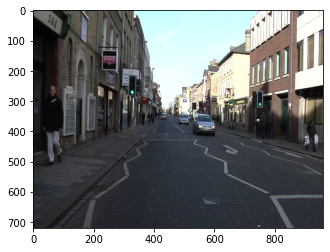

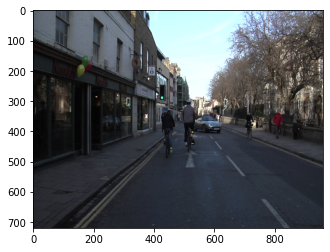

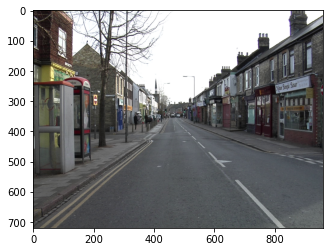

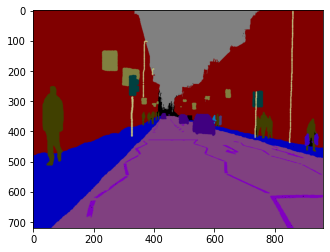

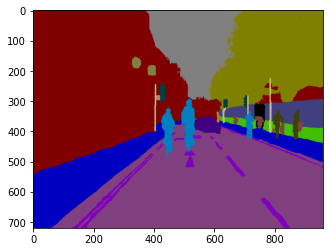

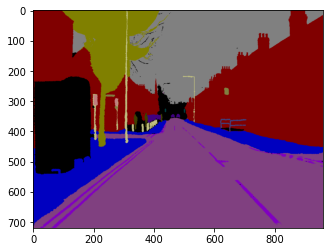

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in ID_test:
  im=image.imread('/content/camvid/images/'+i+'.png')
  plt.imshow(im)
  plt.figure()

for i in ID_test:
  im=image.imread('/content/LabeledApproved_full/'+i+'_L.png')
  plt.imshow(im)
  plt.figure()

In [ ]:
pic1=outputs_test[0]
pic1=pic1.cpu()
pic_1=np.copy(pic1.detach().numpy())
pic_1=np.argmax(pic_1,axis=0)
pic2=outputs_test[1]
pic2=pic2.cpu()
pic_2=np.copy(pic2.detach().numpy())
pic_2=np.argmax(pic_2,axis=0)
pic3=outputs_test[2]
pic3=pic3.cpu()
pic_3=np.copy(pic3.detach().numpy())
pic_3=np.argmax(pic_3,axis=0)

In [ ]:
def out_to_class(out,dic):
  arr=np.zeros((360,480,3))
  for i in range(360):
    for j in range(480):
      arr[i,j,:]=dic[out[i][j]]
  plt.imshow(arr/255)

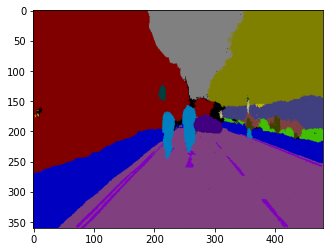

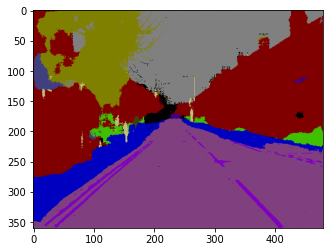

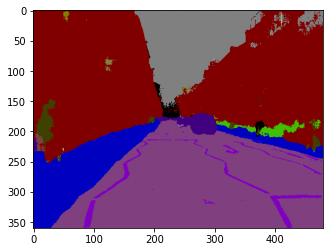

In [ ]:
out_to_class(pic_1,classes_num)
plt.figure()
out_to_class(pic_2,classes_num)
plt.figure()
out_to_class(pic_3,classes_num)